In [133]:
import warnings
warnings.filterwarnings('ignore')

In [134]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
import nltk
import re
from nltk.stem.snowball import SnowballStemmer 
stemmer = SnowballStemmer("russian")
from tqdm import tqdm
import matplotlib.pyplot as plt  
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
import string
from nltk import word_tokenize
from sklearn.linear_model import LogisticRegression

In [135]:
from nltk.stem import *
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
mystem = Mystem() 

In [136]:
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import precision_score,precision_recall_fscore_support,balanced_accuracy_score

In [137]:
def remove_punctuation(text):
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])

def remove_numbers(text):
    return ''.join([i if not i.isdigit() else ' ' for i in text])

def remove_multiple_spaces(text):
	return re.sub(r'\s+', ' ', text, flags=re.I)


russian_stopwords = ['и', 'в', 'во', 'что', 'он', 'на', 'я', 'как', 'а', 'то', 'все', 'она', 'так',
                     'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы',    'за', 'бы', 'по', 'только', 
                     'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще',  'о', 'из', 'ему', 'теперь', 
                     'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 
                     'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 
                     'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 
                     'может', 'они',  'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 
                     'их', 'чем', 'была', 'сам', 'чтоб',  'будто', 'чего', 'раз', 'тоже', 'себе', 
                     'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой',
                     'совсем', 'ним',  'этом', 'один', 'почти', 'мой', 'тем', 'чтобы',
                     'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 
                     'наконец', 'два', 'об',  'хоть', 'после', 'над',  'тот', 
                     'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая',  'разве', 
                     'три', 'эту', 'моя', 'впрочем', 'хорошо', 'свою', 'этой', 'перед', 
                     'иногда', 'лучше', 'чуть', 'том', 'нельзя', 'такой', 'им',  
                     'всегда', 'конечно', 'всю', 'между','…', '«', '»', '...''…', '«', '»', '...']



In [138]:
def text_processing(df,feature):
    df['text_prep']=[remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower()))) for text in tqdm(df[feature].astype(str))]
    stemmed_texts_list = []
    df=df.drop_duplicates(subset=[feature])
    for text in tqdm(df['text_prep']):
        tokens = word_tokenize(text)    
        stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in russian_stopwords]
        text = " ".join(stemmed_tokens)
        stemmed_texts_list.append(text)
    df['text_stem'] = stemmed_texts_list
    df_prep=df.drop_duplicates(subset=['text_stem'])
    df_prep.reset_index(inplace=True)
    return df_prep

In [195]:
def classification(df,feature,target,n_estimators):
    
    v = TfidfVectorizer(decode_error='replace', encoding='utf-8',ngram_range=(1,2))
    X = v.fit_transform(df[feature]).toarray()
    y=df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)
    
    clf = XGBClassifier(objective='multi:softprob',n_estimators=n_estimators)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    
    return clf,X_test, y_test,y_pred,X_train, y_train,v

In [140]:
def feature_importance(clf,v):
    vocab = v.get_feature_names()
    feature_importances = clf.feature_importances_

    for f_idx in np.argsort(feature_importances)[::-1]:
        word = vocab[f_idx]
        importance = feature_importances[f_idx]
        if importance > 0:
            print(word, importance)

## Файл КТ с 4 классами: норма, вирусная пневмония, онкология, иные патологии 

In [149]:
four_class=pd.read_excel('C:/Users/l.soina/Downloads/Telegram Desktop/four_class_unique_onlytext_prep.xlsx')

In [150]:
four_class.head()

,Наименование процедуры_x,Описание исследования_x,Заключение по исследованию,Патология
0,Компьютерная томография органов грудной полости,\n\n Легкие без очаговых и инфильтрат...,\n\n КТ данные вирусной пневмонии (в ...,0
1,Компьютерная томография органов грудной полости,\n\n Очагов и инфильтратов не выявлен...,\n\n Органы грудной полости без видим...,0
2,НДКТ для обследования медицинских работников,"\n\nИсследование в проекте НДКТ \nЭЭД 0,09...",\n\n КТ данных за очаговые и инфильтра...,0
3,Компьютерная томография органов грудной полости,\n\n Пневматизация легочной паренхимы не и...,\n\n Без свежих очаговых и инфильтративных...,0
4,Компьютерная томография органов грудной полости,\n\nПневматизация легочной паренхимы не измене...,\n\n Патологических изменений в органах гр...,0


In [151]:
four_class_unique_onlytext_prep=text_processing(four_class,'Заключение по исследованию')

100%|█████████████████████████████████████████████████████████████████████████████| 5573/5573 [00:08<00:00, 677.76it/s]


In [235]:
clf,X_test, y_test,y_pred,X_train, y_train,vectorizer=classification(four_class_unique_onlytext_prep,'text_stem','Патология',40)

[14:49:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [206]:
feature_importance(clf,vectorizer)

тяжел 0.047944553
онколог 0.033409983
норм 0.031574104
дан предыдущ 0.029616896
mts 0.024617715
отсутств кт 0.023824872
тяжест 0.023006402
свеж 0.020417666
кт дан 0.018422045
кт легк 0.017628485
выявля 0.017407093
отсутств 0.017367434
не связа 0.017302802
солидн 0.01623779
не 0.016107414
опухол 0.01404319
мтс 0.013904471
cr 0.013613496
новообразован 0.013330459
метастатическ 0.012872308
проч проч 0.011532435
образован 0.011217202
выявл 0.011176811
не обнаруж 0.009933749
вирусн 0.009699659
поражен 0.008995351
инфильтративн 0.008521065
дан заключен 0.008452605
кт норм 0.008276329
картин двухсторон 0.0081067765
центральн 0.007034764
covid не 0.006580797
очаг 0.006562585
исследован не 0.0064566378
грудн клетк 0.006193899
вторичн 0.006020708
распространен опухолев 0.0054092156
кт картин 0.005365226
участк 0.00525515
вероятн кист 0.0050202673
фиброзн 0.0048447186
слев 0.0047563002
периферическ 0.00465814
легк без 0.004599632
неопластическ 0.0045808535
метастаз 0.004187478
прав 0.004171976
хр

[0]	validation_0-mlogloss:1.00338	validation_0-merror:0.09454	validation_1-mlogloss:1.02740	validation_1-merror:0.14191
[1]	validation_0-mlogloss:0.78631	validation_0-merror:0.08265	validation_1-mlogloss:0.82183	validation_1-merror:0.12475
[2]	validation_0-mlogloss:0.63802	validation_0-merror:0.07189	validation_1-mlogloss:0.68761	validation_1-merror:0.11683
[3]	validation_0-mlogloss:0.52895	validation_0-merror:0.06595	validation_1-mlogloss:0.58585	validation_1-merror:0.11089
[4]	validation_0-mlogloss:0.44640	validation_0-merror:0.06114	validation_1-mlogloss:0.51083	validation_1-merror:0.10231
[5]	validation_0-mlogloss:0.38532	validation_0-merror:0.05576	validation_1-mlogloss:0.45560	validation_1-merror:0.10033
[6]	validation_0-mlogloss:0.33423	validation_0-merror:0.05180	validation_1-mlogloss:0.41428	validation_1-merror:0.09637
[7]	validation_0-mlogloss:0.29627	validation_0-merror:0.04868	validation_1-mlogloss:0.37992	validation_1-merror:0.09439
[8]	validation_0-mlogloss:0.26299	valida

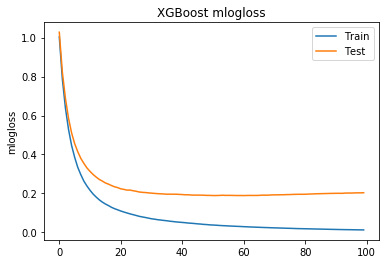

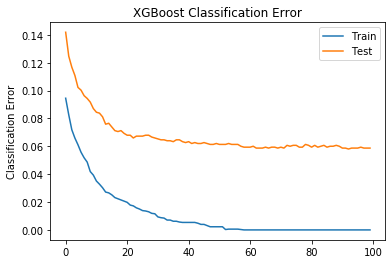

In [154]:
model = XGBClassifier(objective='multi:softprob')
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["mlogloss", "merror"], eval_set=eval_set, verbose=True)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = balanced_accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

results = model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('XGBoost mlogloss')
plt.show()

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

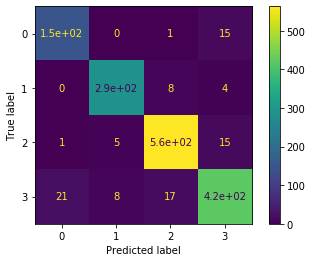

precision [0.87134503 0.95666667 0.95585739 0.92527473]
recall [0.9030303  0.95986622 0.9640411  0.90149893]
fscore [0.88690476 0.95826377 0.9599318  0.9132321 ]
balanced accuracy 0.9321091372481721


In [236]:
plot_confusion_matrix(clf, X_test, y_test)  
prf=precision_recall_fscore_support(y_test, y_pred)
b_accuracy=balanced_accuracy_score(y_test, y_pred)
plt.show() 
print('precision',prf[0])
print('recall',prf[1])
print('fscore',prf[2])
print('balanced accuracy', b_accuracy)

In [239]:
clf_reg = LogisticRegression(random_state=12).fit(X_train, y_train)
y_pred = clf_reg.predict(X_test)

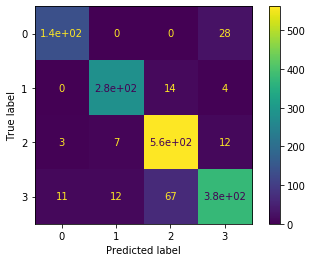

precision [0.90728477 0.93666667 0.87402799 0.89548694]
recall [0.83030303 0.93979933 0.96232877 0.80728051]
fscore [0.86708861 0.93823038 0.91605542 0.8490991 ]
balanced accuracy 0.8849279106121566


In [240]:
plot_confusion_matrix(clf_reg, X_test, y_test)  
prf=precision_recall_fscore_support(y_test, y_pred)
b_accuracy=balanced_accuracy_score(y_test, y_pred)
plt.show() 
print('precision',prf[0])
print('recall',prf[1])
print('fscore',prf[2])
print('balanced accuracy', b_accuracy)

## РГ

In [184]:
RG=pd.read_excel('C:/Users/l.soina/Downloads/RGall.xlsx')

In [185]:
RG.head(2)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Наименование ИИ,Уникальный идентификатор исследования,Наименование процедуры,МО,Ae-title,Модальность,...,Время окончания обработки моделью ИИ,Автор заключения,Описание исследования,Заключение по исследованию,"0 - норма, 1 - патология в рамках базовых требований, 2 -патология вне базовых требований","Патология по базовым требованиям: 1 - выпот, 2 - пневмоторакс, 3 - ателектаз, 4 - очаг затемнения, 5 - инфильтрация/консолидация, 6 - диссеминация, 7 - полость с распадом/уровнем жидкости, 8 - кальцинат, 9 - перелом ребра, грудины, ГОП",Патология вне требований,норма/иное,"норма, вероятность",лейбл
0,0,19,27.0,27.0,Care Mentor AI,1.2.40.0.13.1.19721924444767468743274942416466...,Rg-графия органов грудной клетки,"ГБУЗ ""ГП № 218 ДЗМ"", Филиал № 1",TERRA_GP218F1,РГ,...,2020-07-28 10:21:02,Соломатина Елена Сергеевна,\n\nна рентгенограммах органов грудной клетки ...,\n\nДиф. пневмофиброз; четких рентгенологическ...,1.0,6,NaN,NaN,NaN,NaN
1,1,20,28.0,28.0,Care Mentor AI,1.2.392.200036.9116.32.4.2011.9728095434.1573.710,Rg-графия органов грудной клетки,"ГБУЗ ""КДЦ № 6 ДЗМ"", Филиал № 2",PDR02A_KDC6F2,РГ,...,2020-07-28 09:59:13,Сорокина Ольга Вадимовна,\n\nКлиническая информация:\nВыполнена рентген...,\n\n Рентгенологических признаков воспалительн...,1.0,5,NaN,NaN,NaN,NaN


In [186]:
RG=RG[['Заключение по исследованию','0 - норма, 1 - патология в рамках базовых требований, 2 -патология вне базовых требований']]\
.dropna(subset=['0 - норма, 1 - патология в рамках базовых требований, 2 -патология вне базовых требований'])

In [187]:
RG.columns=['Заключение','Патология']

In [188]:
RG.head(3)

,Заключение,Патология
0,\n\nДиф. пневмофиброз; четких рентгенологическ...,1.0
1,\n\n Рентгенологических признаков воспалительн...,1.0
2,\n\n Рентгенологических признаков патологическ...,0.0


In [189]:
RG_prep=text_processing(RG,'Заключение')

100%|██████████████████████████████████████████████████████████████████████████████| 565/565 [00:00<00:00, 1387.77it/s]


In [190]:
RG_prep.head(3)

,index,Заключение,Патология,text_prep,text_stem
0,0,\n\nДиф. пневмофиброз; четких рентгенологическ...,1.0,диф пневмофиброз четких рентгенологических да...,диф пневмофиброз четк рентгенологическ дан вто...
1,1,\n\n Рентгенологических признаков воспалительн...,1.0,рентгенологических признаков воспалительных и...,рентгенологическ признак воспалительн изменен ...
2,2,\n\n Рентгенологических признаков патологическ...,0.0,рентгенологических признаков патологических и...,рентгенологическ признак патологическ изменен ...


In [207]:
clf,X_test, y_test,y_pred,X_train, y_train,vectorizer=classification(RG_prep,'text_stem','Патология',20)

[14:30:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [208]:
feature_importance(clf,vectorizer)

возрастн 0.045750245
инфильтративн тен 0.031731505
фиброз 0.030618869
не 0.030284002
мзв 0.028243639
эмфизем 0.02729866
ребр справ 0.025865847
локальн фиброз 0.025657255
аорт 0.023430245
туберкулез 0.021584935
дуг 0.021133617
средостен 0.01980079
кт 0.01942434
пневмон 0.015863711
без 0.015677795
пневмофиброз 0.015671447
гидроторакс 0.015426985
прав легк 0.014928944
инфильтративн 0.014418585
без свеж 0.0144156385
инфильтративн изменен 0.014336357
справ 0.014287243
пневмосклероз 0.013164157
картин 0.012092858
изменен 0.012090922
кардиомегал 0.011844594
легочн пол 0.011740575
легочн 0.011499083
свеж очагов 0.011421888
рекомендова 0.011376539
слев 0.010839051
поствоспалительн 0.010825282
отдел позвоночник 0.010603442
клиническ 0.010427114
изменен легк 0.009632065
грудн 0.009589326
признак диф 0.009443748
динамик 0.009340252
рг 0.009123736
видим 0.009058698
без существен 0.008889641
момент 0.008806018
клетк 0.008766471
тен 0.008363588
не определя 0.007952197
фиброзн 0.007943103
орган 0.0077

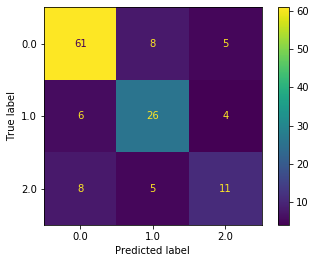

precision [0.81333333 0.66666667 0.55      ]
recall [0.82432432 0.72222222 0.45833333]
fscore [0.81879195 0.69333333 0.5       ]
balanced accuracy 0.6682932932932933


In [209]:
plot_confusion_matrix(clf, X_test, y_test)  
prf=precision_recall_fscore_support(y_test, y_pred)
b_accuracy=balanced_accuracy_score(y_test, y_pred)
plt.show() 
print('precision',prf[0])
print('recall',prf[1])
print('fscore',prf[2])
print('balanced accuracy', b_accuracy)

[0]	validation_0-mlogloss:0.86601	validation_0-merror:0.13548	validation_1-mlogloss:0.94695	validation_1-merror:0.30597
[1]	validation_0-mlogloss:0.72113	validation_0-merror:0.11936	validation_1-mlogloss:0.87826	validation_1-merror:0.35821
[2]	validation_0-mlogloss:0.62364	validation_0-merror:0.10323	validation_1-mlogloss:0.82796	validation_1-merror:0.34328
[3]	validation_0-mlogloss:0.53778	validation_0-merror:0.08064	validation_1-mlogloss:0.78831	validation_1-merror:0.30597
[4]	validation_0-mlogloss:0.48045	validation_0-merror:0.07097	validation_1-mlogloss:0.74767	validation_1-merror:0.27612
[5]	validation_0-mlogloss:0.41624	validation_0-merror:0.04839	validation_1-mlogloss:0.74006	validation_1-merror:0.27612
[6]	validation_0-mlogloss:0.37794	validation_0-merror:0.05484	validation_1-mlogloss:0.72208	validation_1-merror:0.29104
[7]	validation_0-mlogloss:0.34890	validation_0-merror:0.05161	validation_1-mlogloss:0.71532	validation_1-merror:0.27612
[8]	validation_0-mlogloss:0.31816	valida

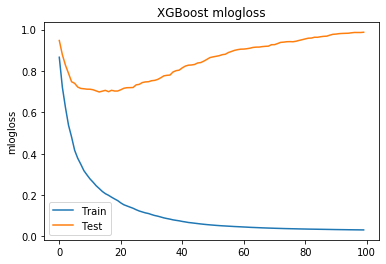

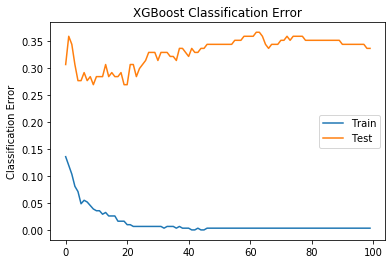

In [199]:
model = XGBClassifier(objective='multi:softprob')
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["mlogloss", "merror"], eval_set=eval_set, verbose=True)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = balanced_accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

results = model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('XGBoost mlogloss')
plt.show()

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [211]:
y_train.to_frame().reset_index().groupby('Патология').count()

,index
Патология,
0.0,152
1.0,92
2.0,66


In [212]:
y_test.to_frame().reset_index().groupby('Патология').count()

,index
Патология,
0.0,74
1.0,36
2.0,24


## ФЛГ

In [213]:
FLG=pd.read_excel('C:/Users/l.soina/Downloads/флг_1.xlsx')
FLG.head(1)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Наименование ИИ,Уникальный идентификатор исследования,Наименование процедуры,МО,Ae-title,Модальность,Дата отправки исследования в PACS,Дата создания заключения,Возраст пациента,Время начала обработки моделью ИИ,Время окончания обработки моделью ИИ,Автор заключения,Описание исследования,Заключение по исследованию,"0 - норма, 1 - патология в рамках базовых требований, 2 -патология вне базовых требований","Патология по базовым требованиям: 1 - выпот, 2 - пневмоторакс, 3 - ателектаз, 4 - очаг затемнения, 5 - инфильтрация/консолидация, 6 - диссеминация, 7 - полость с распадом/уровнем жидкости, 8 - кальцинат, 9 - перелом ребра, грудины, ГОП",Патология вне требований
0,11,18,18,Цельс ФЛГ,1.871.3.1427050605.36698.17300.3112620700.8171...,Флюорография легких профилактическая,"Филиал ГБУЗ ""МНПЦ борьбы с туберкулезом ДЗМ"" п...",RENEXSCU1_PTD13,Флюорограф,22.08.2020 09:38:00,2020-08-24 08:43:00,49,2020-08-22 09:39:33,2020-08-22 09:39:39,Иноземцева Алла Борисовна,\n\nЛегочные поля прозрачные. Корни структурны...,\n\nПатологические изменения не определяются.\...,0.0,NaN,NaN


In [215]:
FLG=FLG[['Заключение по исследованию','0 - норма, 1 - патология в рамках базовых требований, 2 -патология вне базовых требований']]\
.dropna(subset=['0 - норма, 1 - патология в рамках базовых требований, 2 -патология вне базовых требований'])
len(FLG)

996

In [216]:
FLG.head()

,Заключение по исследованию,"0 - норма, 1 - патология в рамках базовых требований, 2 -патология вне базовых требований"
0,\n\nПатологические изменения не определяются.\...,0.0
1,\n\nОрганы грудной клетки без патологических и...,0.0
2,\n\nПатологических изменений в органах грудной...,0.0
3,\n\nЗаключение: без свежих очаговых и инфильтр...,0.0
4,\n\nОчаговых и инфильтративных изменений не оп...,0.0


In [218]:
FLG.columns=['Заключение','Патология']

In [221]:
FLG_prep=text_processing(FLG,'Заключение')

100%|███████████████████████████████████████████████████████████████████████████████| 418/418 [00:00<00:00, 512.94it/s]


In [227]:
clf,X_test, y_test,y_pred,X_train, y_train,vectorizer=classification(FLG_prep,'text_stem','Патология',12)

[14:39:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


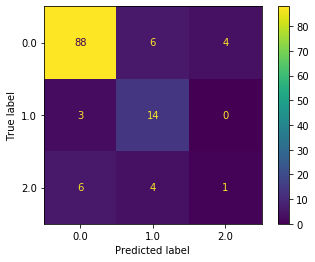

precision [0.90721649 0.58333333 0.2       ]
recall [0.89795918 0.82352941 0.09090909]
fscore [0.9025641  0.68292683 0.125     ]
balanced accuracy 0.6041325621157553


In [228]:
plot_confusion_matrix(clf, X_test, y_test)  
prf=precision_recall_fscore_support(y_test, y_pred)
b_accuracy=balanced_accuracy_score(y_test, y_pred)
plt.show() 
print('precision',prf[0])
print('recall',prf[1])
print('fscore',prf[2])
print('balanced accuracy', b_accuracy)

In [229]:
y_train.to_frame().reset_index().groupby('Патология').count()

,index
Патология,
0.0,210
1.0,59
2.0,23


In [230]:
y_test.to_frame().reset_index().groupby('Патология').count()

,index
Патология,
0.0,98
1.0,17
2.0,11


[0]	validation_0-mlogloss:0.82493	validation_0-merror:0.13014	validation_1-mlogloss:0.85186	validation_1-merror:0.14286
[1]	validation_0-mlogloss:0.66346	validation_0-merror:0.12671	validation_1-mlogloss:0.71724	validation_1-merror:0.15079
[2]	validation_0-mlogloss:0.54653	validation_0-merror:0.12671	validation_1-mlogloss:0.63380	validation_1-merror:0.16667
[3]	validation_0-mlogloss:0.45055	validation_0-merror:0.09589	validation_1-mlogloss:0.58368	validation_1-merror:0.16667
[4]	validation_0-mlogloss:0.38069	validation_0-merror:0.08562	validation_1-mlogloss:0.54653	validation_1-merror:0.15873
[5]	validation_0-mlogloss:0.32340	validation_0-merror:0.07534	validation_1-mlogloss:0.53452	validation_1-merror:0.15873
[6]	validation_0-mlogloss:0.28583	validation_0-merror:0.06507	validation_1-mlogloss:0.51090	validation_1-merror:0.15873
[7]	validation_0-mlogloss:0.24962	validation_0-merror:0.05822	validation_1-mlogloss:0.50505	validation_1-merror:0.15873
[8]	validation_0-mlogloss:0.22045	valida

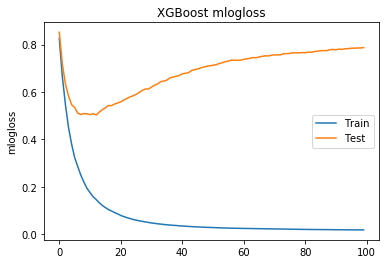

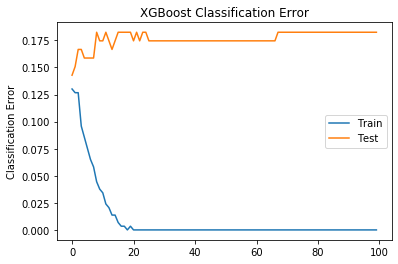

In [226]:
model = XGBClassifier(objective='multi:softprob')
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["mlogloss", "merror"], eval_set=eval_set, verbose=True)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = balanced_accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

results = model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('XGBoost mlogloss')
plt.show()

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

LogisticRegression

In [233]:
clf_reg = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf_reg.predict(X_test)

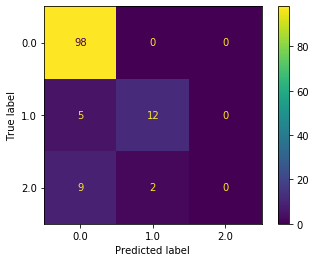

precision [0.875      0.85714286 0.        ]
recall [1.         0.70588235 0.        ]
fscore [0.93333333 0.77419355 0.        ]
balanced accuracy 0.5686274509803922


In [234]:
plot_confusion_matrix(clf_reg, X_test, y_test)  
prf=precision_recall_fscore_support(y_test, y_pred)
b_accuracy=balanced_accuracy_score(y_test, y_pred)
plt.show() 
print('precision',prf[0])
print('recall',prf[1])
print('fscore',prf[2])
print('balanced accuracy', b_accuracy)